In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import jit

# Computational Essay
By Roy Lim z5310629

## Intro & Background

## Results

### Part A
We can solve the Hamiltonian:
$$
    H = 
    \begin{bmatrix}
    E & t \\
    t* & -E \\ 
    \end{bmatrix}
$$
to get the following eigenvalues: $\lambda_1 = -\sqrt{t^2 + E^2} $, $\lambda_2 = \sqrt{t^2 + E^2}$ and given eigenvectors:
$$
    | \lambda_2 \rangle = 
    \begin{bmatrix}
        E - \sqrt{t^2 + E^2} \\ 
        t
    \end{bmatrix}
    | \lambda_2 \rangle = 
    \begin{bmatrix}
       E + \sqrt{t^2 + E^2} \\ 
       t 
    \end{bmatrix}
$$
Therefore $E_2 - E_1 = 2\sqrt{t^2 + E^2}$, min value for $E_2 - E_1$ is $2t$

For an energy state $| \lambda \rangle = \begin{bmatrix} a \\ b\end{bmatrix}$, the probability of being in state $|0\rangle$ and $|1\rangle$ is $|a|^2$ and $|b|^2$ respectively.
Note that $|a|^2 + |b|^2 = 1$ and that $t$ is real (meaning $t* = t$)

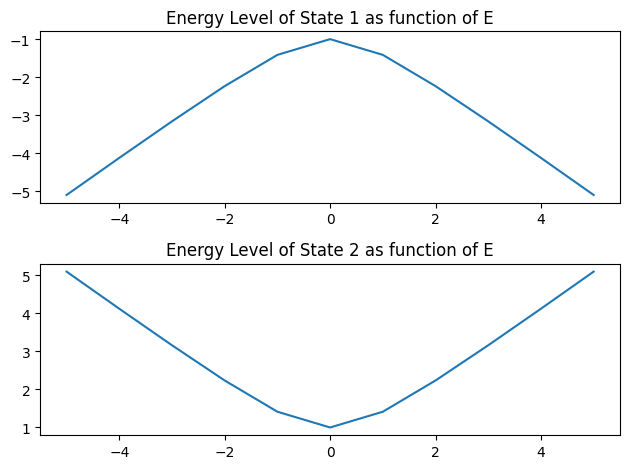

In [2]:
t = 1
E = [e for e in range(-5, 6)]
fig, axes = plt.subplots(2)
state1 = axes[0]
state2 = axes[1]
state1.plot([e for e in E], [-np.sqrt(t ** 2 + e ** 2)for e in E])
state1.set_title('Energy Level of State 1 as function of E')
state2.plot([e for e in E], [np.sqrt(t ** 2 + e ** 2)for e in E])
state2.set_title('Energy Level of State 2 as function of E')
plt.tight_layout()

In [3]:
# a = E, b = t
probability_matrix = [
    [
        lambda a, b: (a + np.sqrt(a ** 2 + b ** 2)) ** 2 / ((a + np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
        lambda a, b:  b ** 2 / ((a + np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
    ],
    [
        lambda a, b: (a - np.sqrt(a ** 2 + b ** 2)) ** 2 / ((a - np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
        lambda a, b:  b ** 2 / ((a - np.sqrt(a ** 2 + b ** 2)) ** 2 + b ** 2),
    ]
]

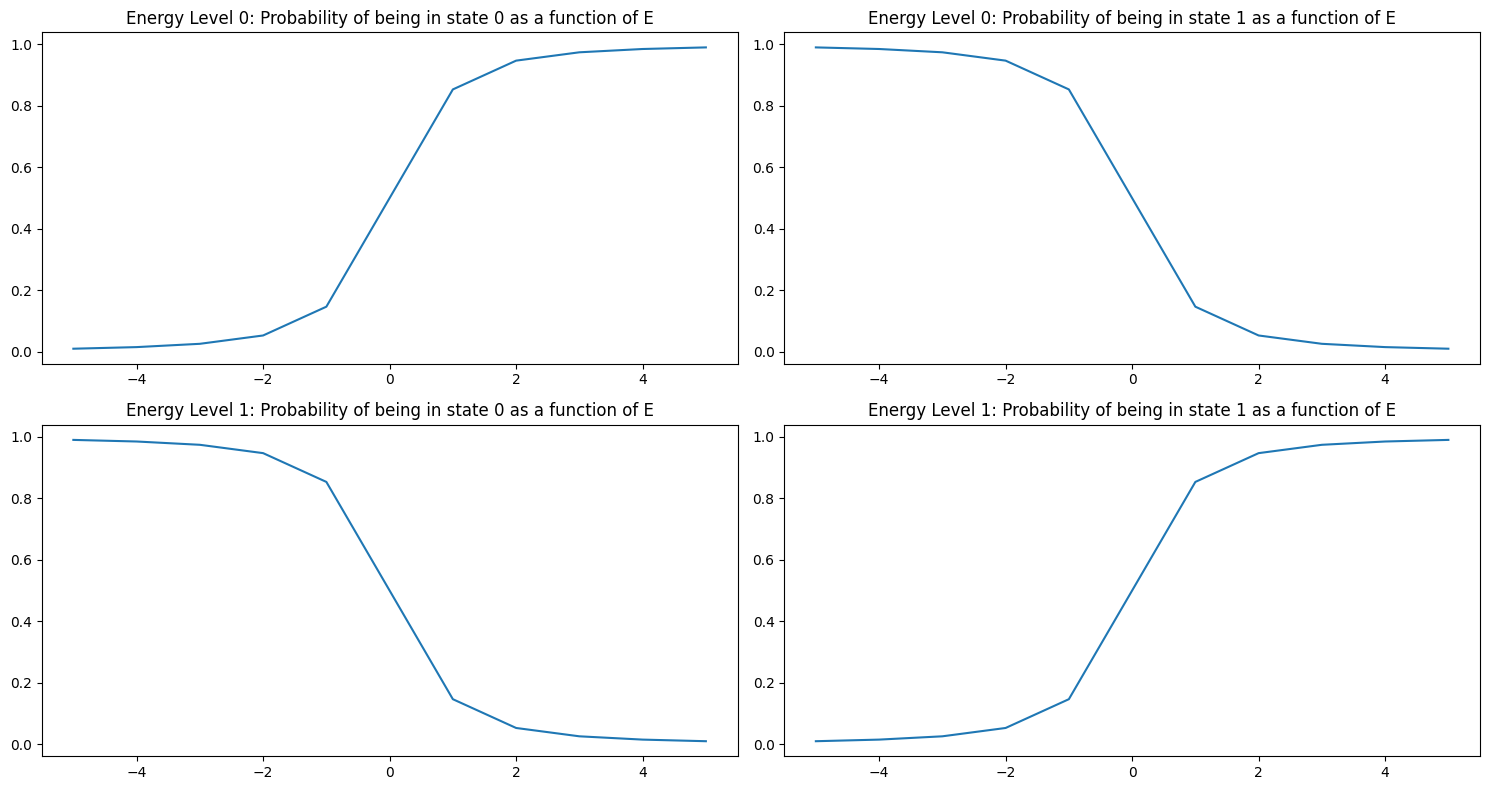

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
for energy_level in [0, 1]:
    for state in [0, 1]:
        ax = axes[energy_level, state]
        ax.plot([e for e in E], [probability_matrix[energy_level][state](e, t) for e in E], '-')
        ax.set_title(f'Energy Level {energy_level}: Probability of being in state {state} as a function of E')
        
plt.tight_layout()

### Part B

In [5]:
# Constants
hbar = 1.055e-34      # Js
q = 1.602e-19         # C
m = 9.1e-31           # kg
m_dot = 0.2 * m       # kg  
bohr_radii = 5.29e-11 # m
a = 1e-10             # m

In [6]:
def VQD(alpha, x1, x):
    return alpha * (x - x1) ** 2

def VDQD(alpha, x1, x2, x):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2)

def VF(alpha, F, x1, x2, x):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2) + F * x

def VFT(alpha, F, omega, x1, x2, x, t):
    return alpha * min((x - x1) ** 2, (x - x2) ** 2) + F * x * np.cos(omega * t)

Recall for a 1D Quantum Harmonic Oscillator:
$$
    H = \frac{p^2}{2m} + \frac{1}{2}m\omega^2 x^2
$$,
hence $\alpha = \frac{1}{2} m \omega^2$
Using $\omega = \frac{E_1 - E_0}{\hbar}$, we can deduce that:
$$
\alpha = \frac{1}{2}m ( \frac{(E_1 - E_0)}{\hbar} )^2
$$
Assuming an energy gap of $4 meV$, we get an alpha value of $\approx ??? \frac{eV}{nm^2}$.

In [7]:
print(f'Alpha Estimate (Analytical): {1 / 2 * m_dot * (4 * 1e-3 * q / hbar) ** 2 * 1e-9 ** 2 / q :.2E} eV / nm^2') 

Alpha Estimate (Analytical): 2.10E-05 eV / nm^2


In [8]:
# Constants
Np = 500
X = a * np.linspace(-500, 500, Np) / 1e-9  # nm
# divide by q to convert to eV, accounting for mass of quantum dot ~ 0.2 mass of electron
t0 = hbar ** 2 / (2 * m_dot * ((X[1] - X[0]) * 1e-9) ** 2) / q
on = 2.0 * t0 * np.ones(Np)
off = -t0 * np.ones(Np - 1)
alpha = 2.10e-5 
x1 = 0 # nm

In [9]:
@jit
def compute_eigenvalue_eigenstates(U):
    H = np.diag(on + U) + np.diag(off, 1) + np.diag(off, -1)
    W, V = np.linalg.eig(H)
    idx = W.argsort()[::1]
    W = W[idx]
    V = V[:, idx]
    return W, V

#### Sweeping Potential Energy 

In [10]:
for pow in range(-5, 0):
    alpha_test = 10 ** pow
    U = np.array([VQD(alpha_test, x1,  x) for x in X])
    W, _ = compute_eigenvalue_eigenstates(U)
    print(f'Alpha {alpha_test:.2E} yields Energy Gap of {(W[1] - W[0]) / 1e-3 :.2f} meV')

KeyboardInterrupt: 

#### Computation for Energy Gap of 4meV

In [11]:
U = np.array([VQD(alpha, x1,  x) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

In [12]:
print(f'Energy Gap: {(W[1] - W[0]) / 1e-3} meV')

Energy Gap: 4.003937460034616 meV


In [13]:
Psi0 = np.multiply(V[:, 0], V[:, 0])
Psi1 = np.multiply(V[:, 1], V[:, 1])

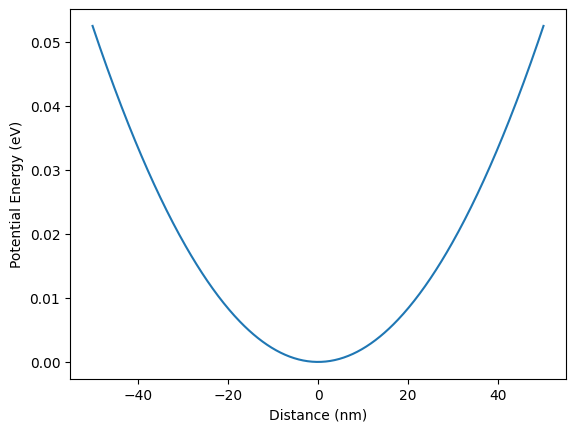

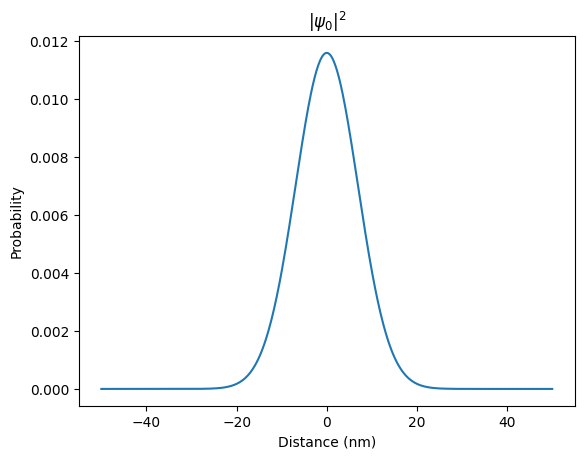

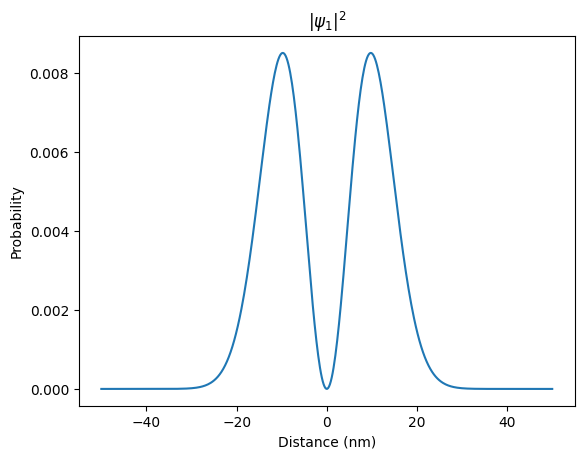

In [14]:
plt.figure(1)
plt.plot(X, U)
plt.xlabel('Distance (nm)')
plt.ylabel('Potential Energy (eV)')
plt.show()

plt.figure(2)
plt.plot(X, Psi0)
plt.xlabel('Distance (nm)')
plt.ylabel('Probability')
plt.title(r'$|\psi_0|^2$')
plt.show()

plt.figure(3)
plt.plot(X, Psi1)
plt.xlabel('Distance (nm)')
plt.ylabel('Probability')
plt.title(r'$|\psi_1|^2$')
plt.show()

In [15]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(x, y, p0):
    popt, _ = curve_fit(gauss, x, y, p0)
    return popt
A, mu, sigma = fit_gaussian(X, Psi0, [.006, 0, 3])
print(f'Number of Atoms Spanned: {2 * sigma * 1e-9 / 0.543e-9:.2F}')

Number of Atoms Spanned: 25.43


#### i)
Given the alpha is related to the potential energy of the gate, used the confined the electron, we can infer that alpha must be related to how the gate interacts with the material.

Thus factors that affect the value may include:
- Voltage applied by the gate
- Distance between gate and trapped electron (e.g. a thicker $SiO_2$ layer could affect alpha)
- The dimensions of the gate / how the voltage is spread out

Temperature range we expect for the device to work would be low (close to 0K), otherwise the thermal fluctuation may cause decoherence.
This is because higher temperature leads to more active electrons and atoms, which increase the likelihood of interaction, leading to decoherence.
Alternatively, high temperature may lead to the confined electrons from moving out of its confinement, thus destroying the ability of it actions as a qubit.  
#### ii)
Potential issues:
- Small Simulation Domain (artificial confinement)
- Inaccurate meshing 
- Finite size effect

Inaccurate meshing can be partially remediated by increasingly the granularity between points.
For instance, I decreased the space from 1 nm to 0.5 nm.

Given that the predicted alpha is close to the analytically derived alpha (predicted is $8.4e-5 eV / nm^2$ while alpha used was around $8e-5 eV / nm^2$), this suggests that the code is accurate.
#### iii)
Quantum dots are called artificial atoms as they have discrete energy levels similar to how electrons do in an atom.
Length scale is 2$\sigma$ of a gaussian fitted on the probability density of being in ground.



### Part C

In [16]:
def plot_graph(x, y, xlabel, ylabel, title, axis=None):
    if axis is not None:
        axis.plot(x, y)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)
    else:
        plt.plot(x, y)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

In [18]:
def plot_graph_x(x, y, xlabel, ylabel, title, axis=None):
    if axis is not None:
        axis.plot(x, y, 'x')
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)
    else:
        plt.plot(x, y, 'x')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

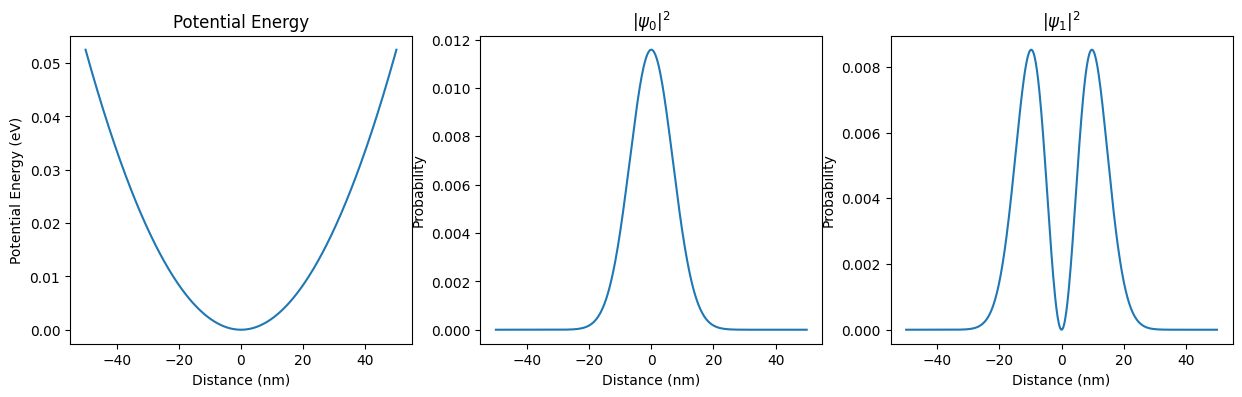

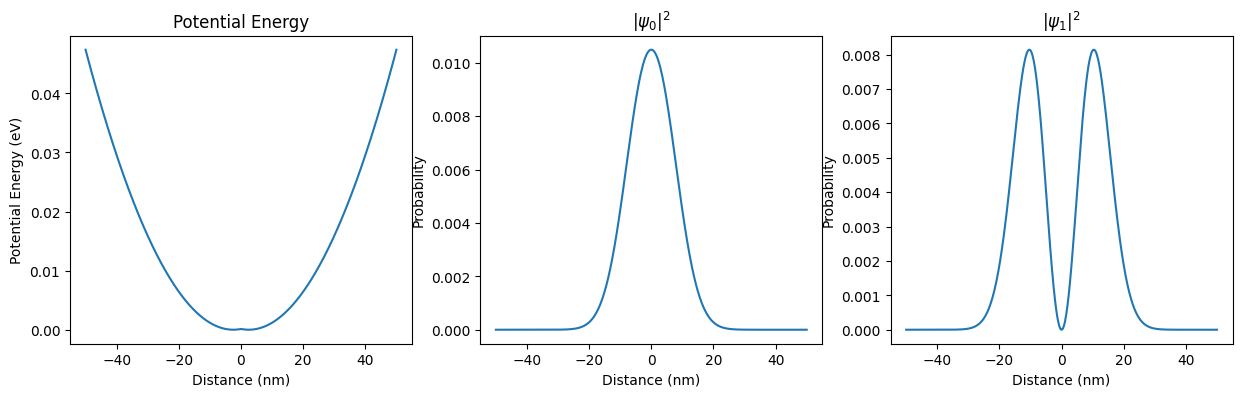

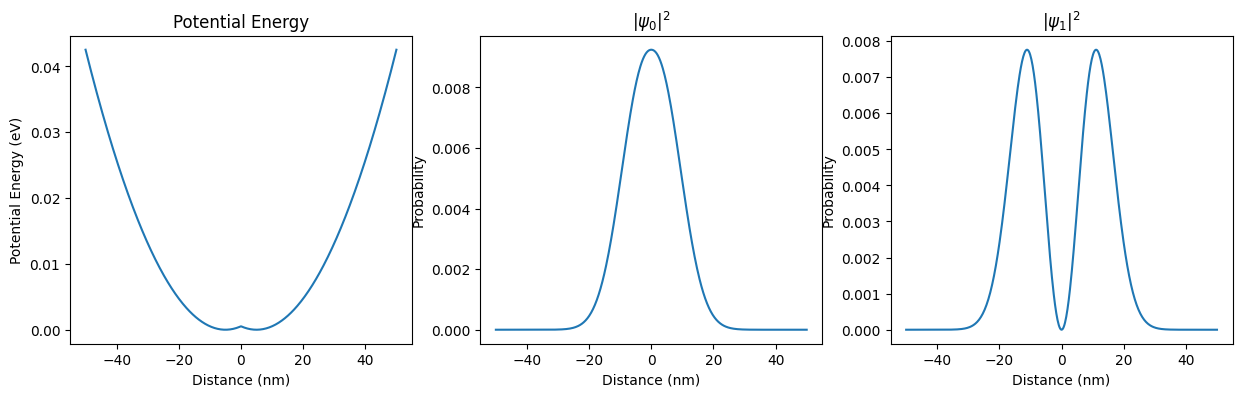

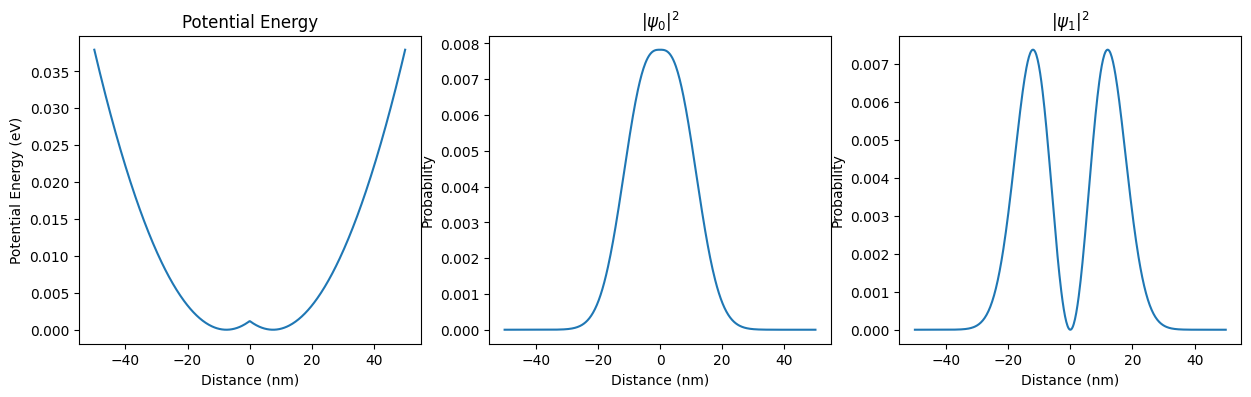

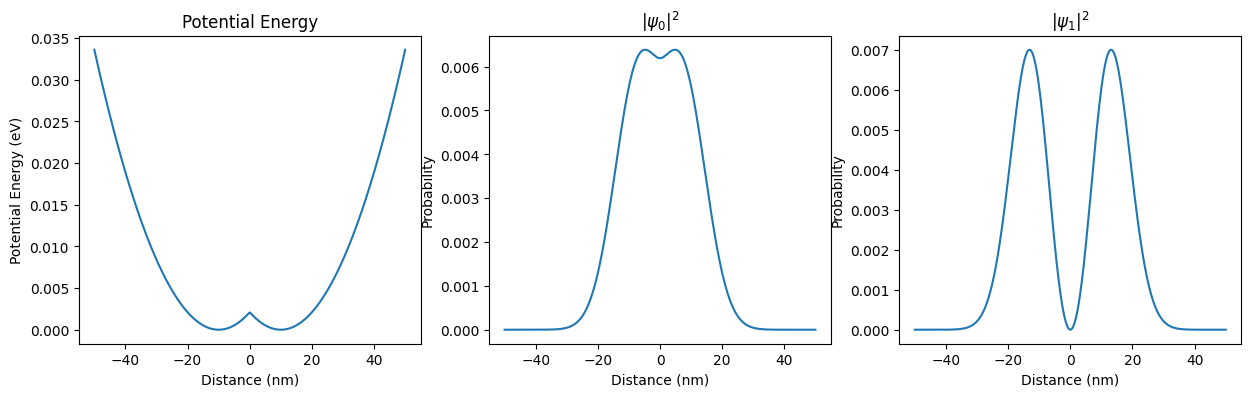

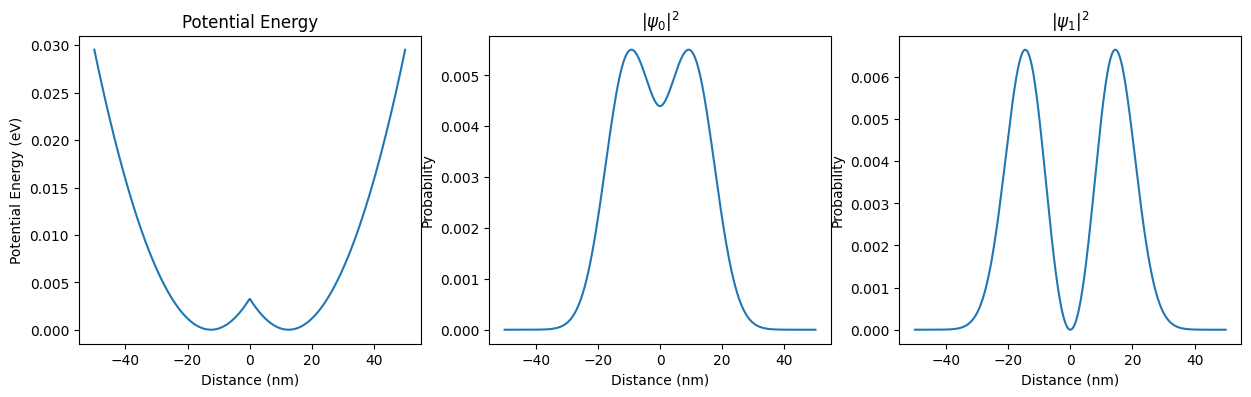

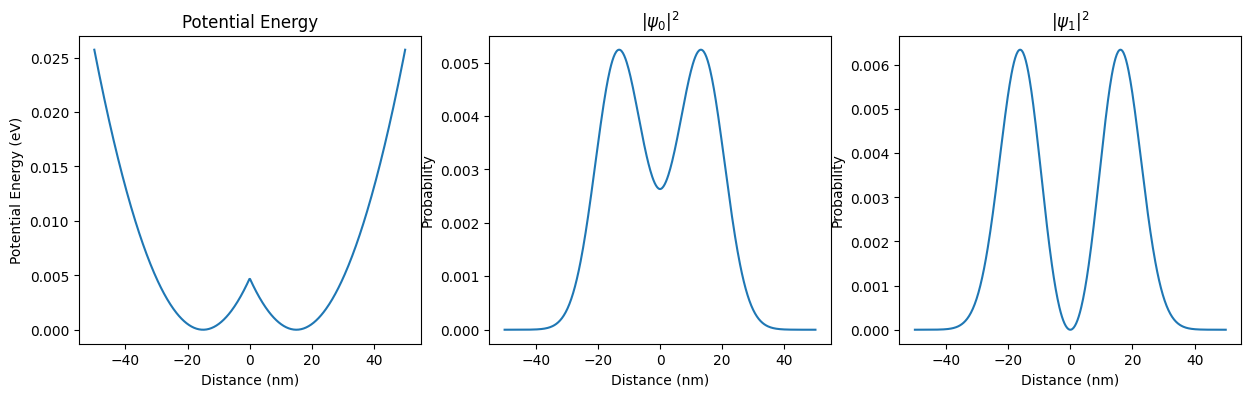

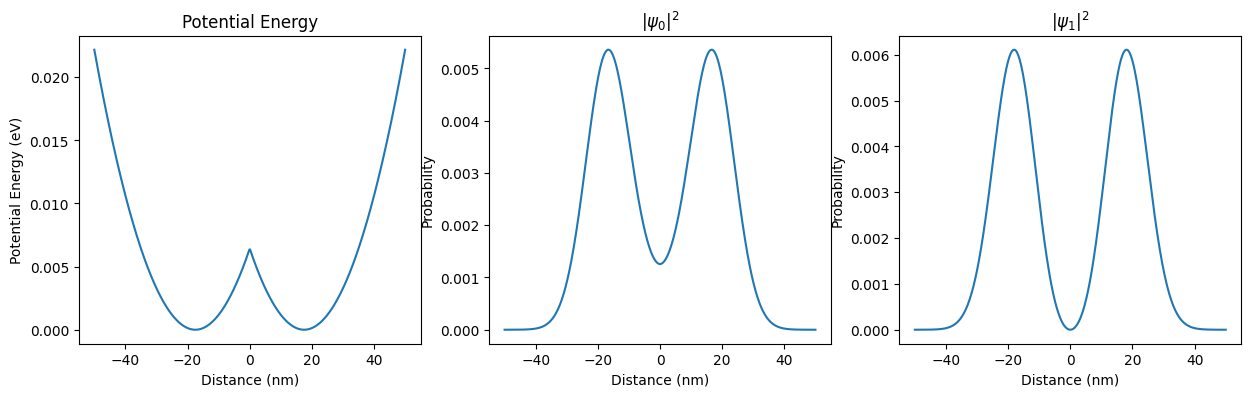

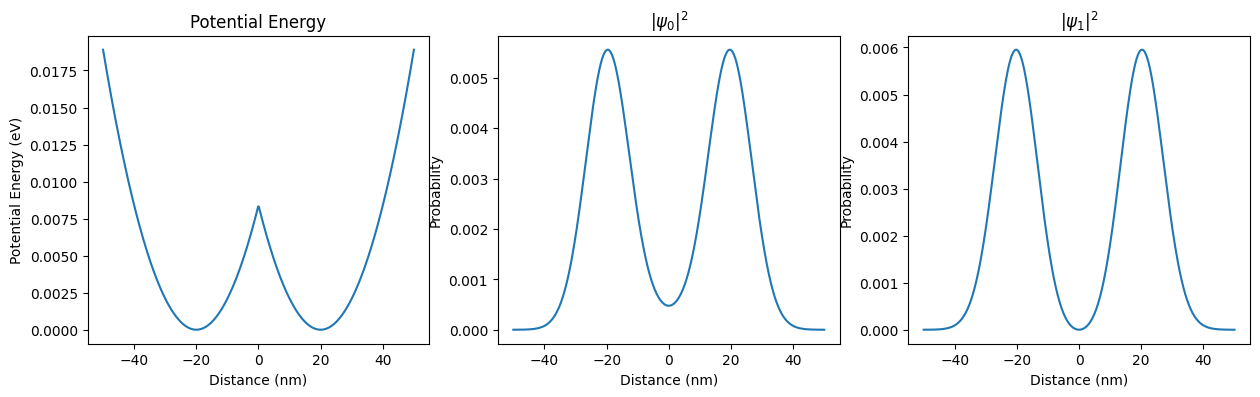

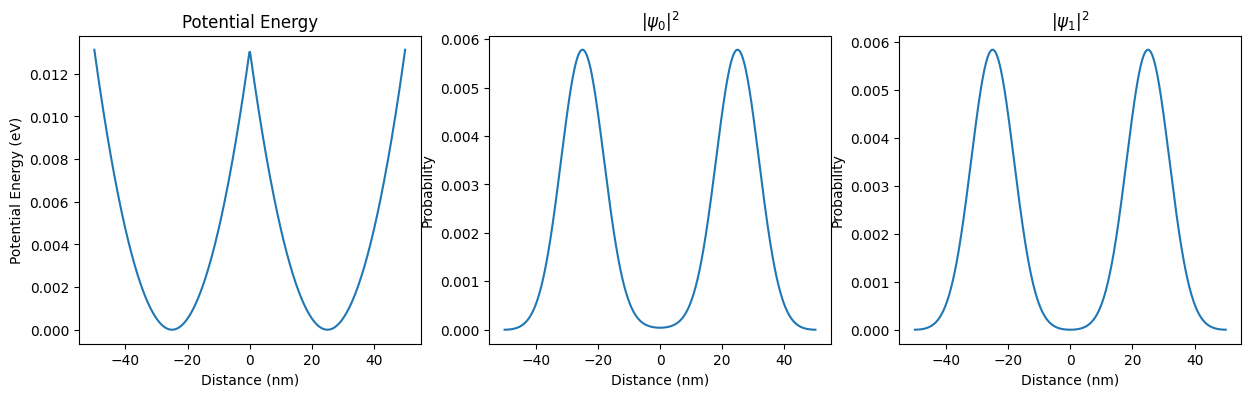

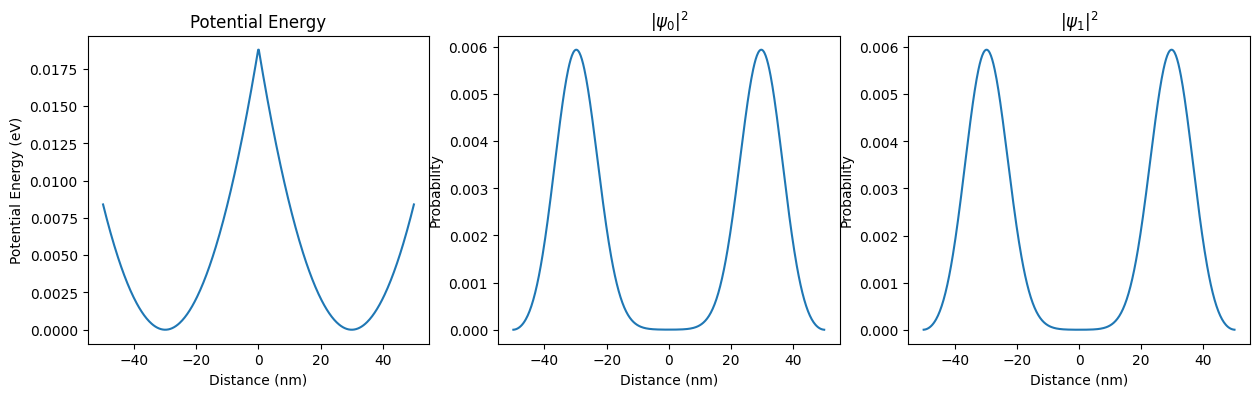

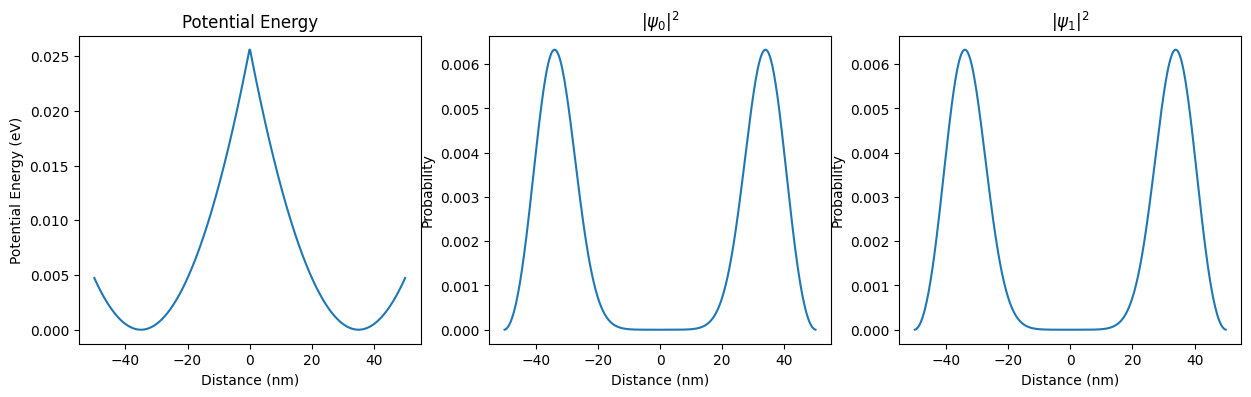

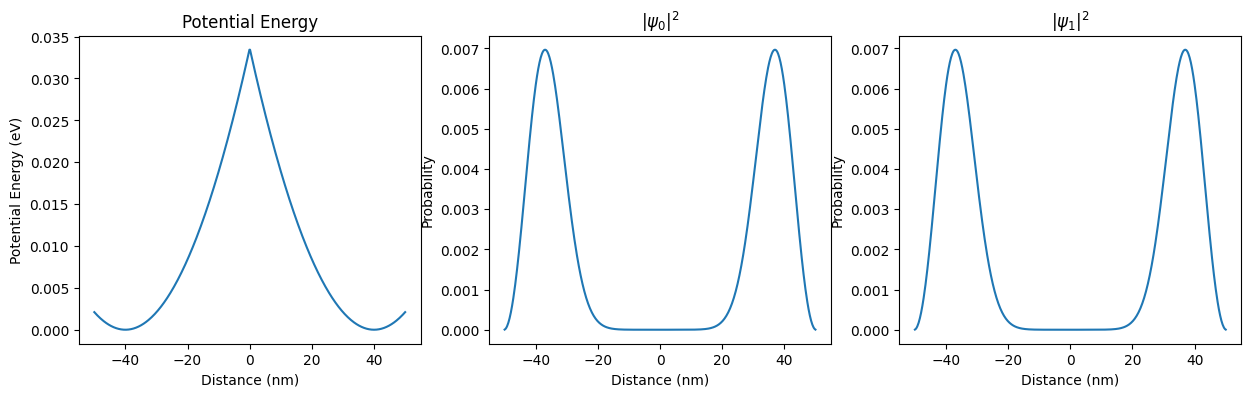

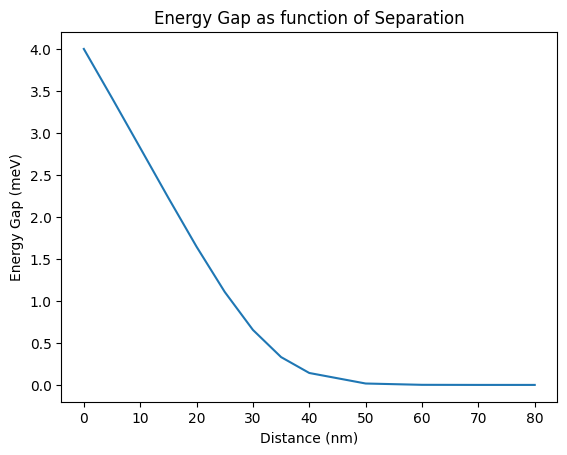

In [19]:
separation = []
energy_difference = []

for index, R in enumerate([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40]):
    x1 = R
    x2 = -R
    # Create Potential Energy and Probability Curves for 2 lowest energy state
    U = np.array([VDQD(alpha, x1, x2, x) for x in X])
    W, V = compute_eigenvalue_eigenstates(U)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    Psi0 = np.multiply(V[:, 0], V[:, 0])
    Psi1 = np.multiply(V[:, 1], V[:, 1])
    plot_graph(X, U, 'Distance (nm)', 'Potential Energy (eV)', r'Potential Energy', axes[0])
    plot_graph(X, Psi0, 'Distance (nm)', 'Probability', r'$|\psi_0|^2$', axes[1])
    plot_graph(X, Psi1, 'Distance (nm)', 'Probability', r'$|\psi_1|^2$', axes[2])
    plt.show()

    # Create data for energy difference per centre-to-centre dot separation
    separation.append(2 * R)
    energy_difference.append((W[1] - W[0]) / 1e-3)

plot_graph(separation, energy_difference, 'Distance (nm)', 'Energy Gap (meV)', 'Energy Gap as function of Separation')

In [30]:
x1 = 10
x2 = -10
U = np.array([VDQD(alpha, x1, x2, x) for x in X])
W, V = compute_eigenvalue_eigenstates(U)

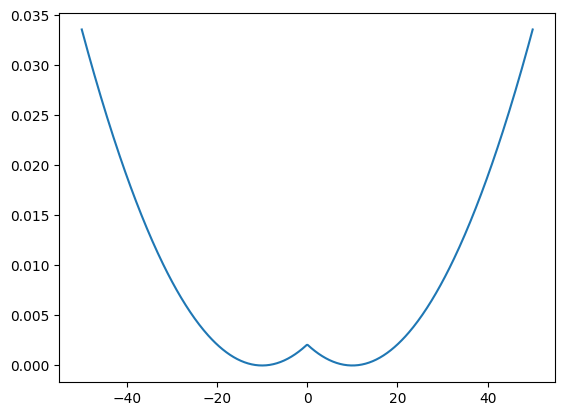

In [31]:
plt.plot(X, U)

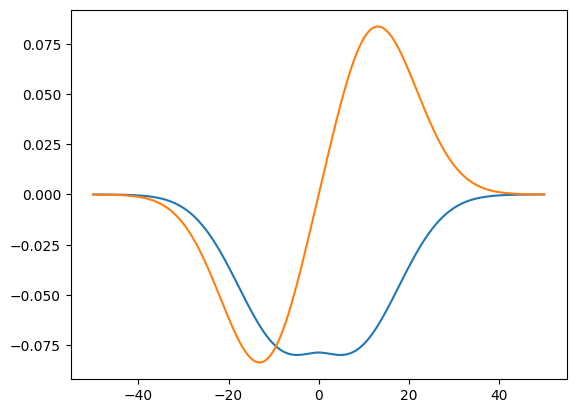

In [32]:
plt.plot(X, V[:, 0])
plt.plot(X, V[:, 1])

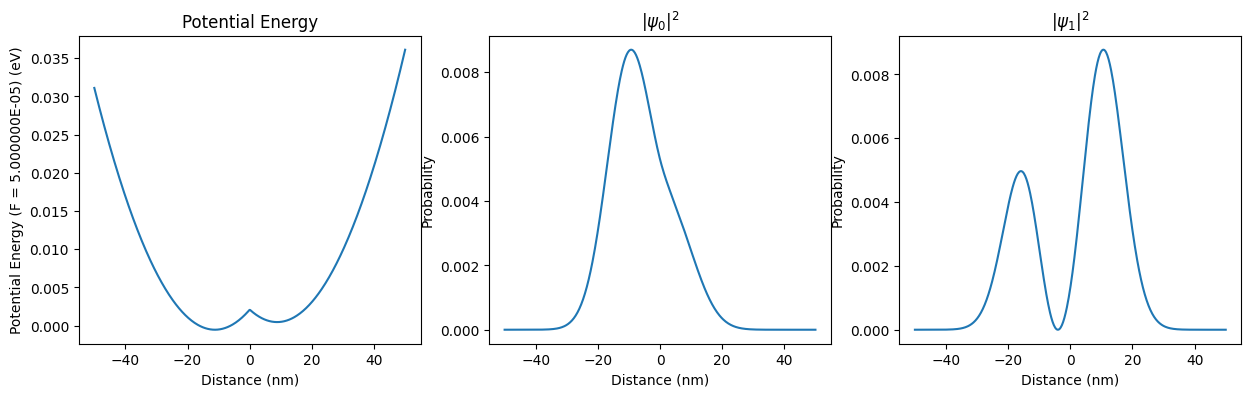

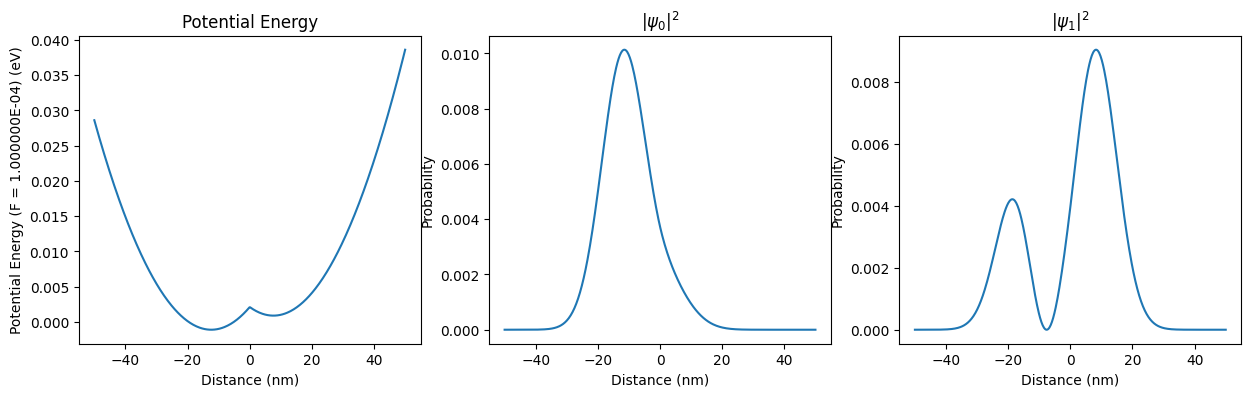

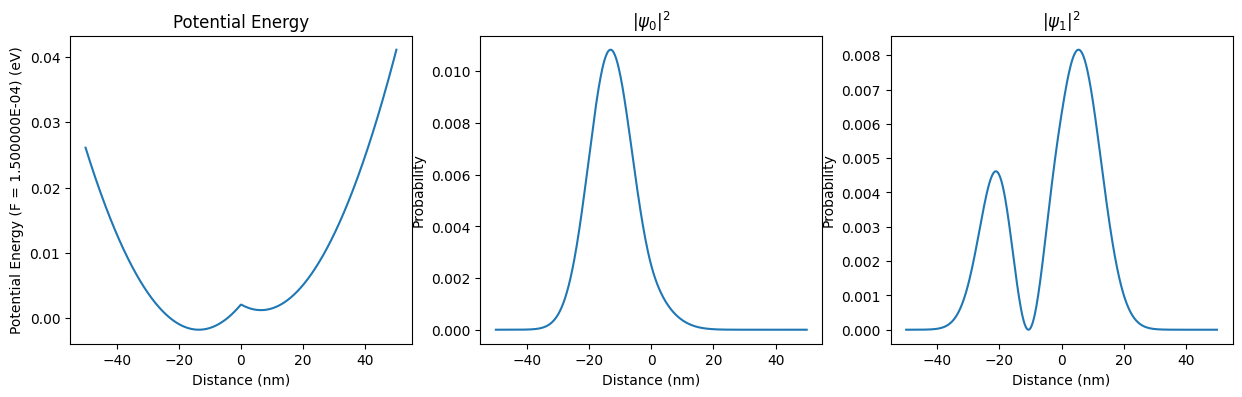

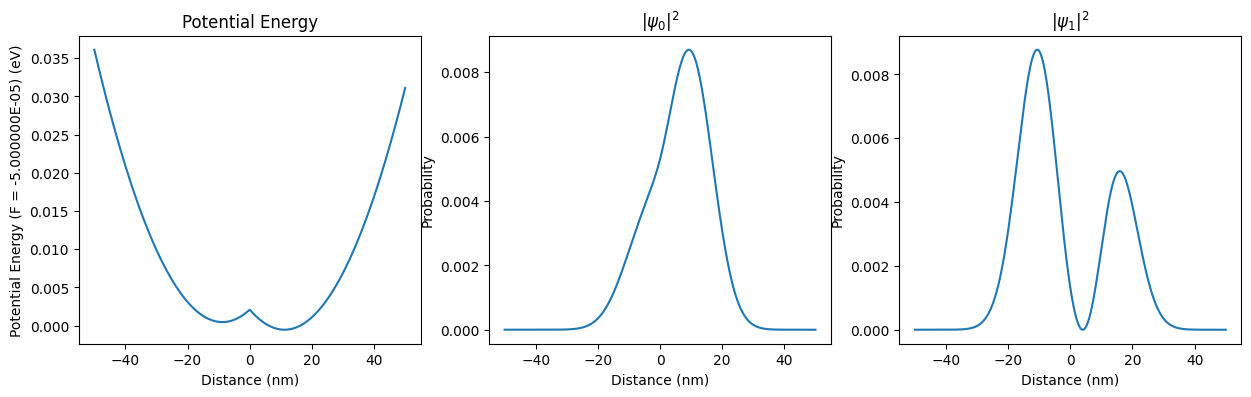

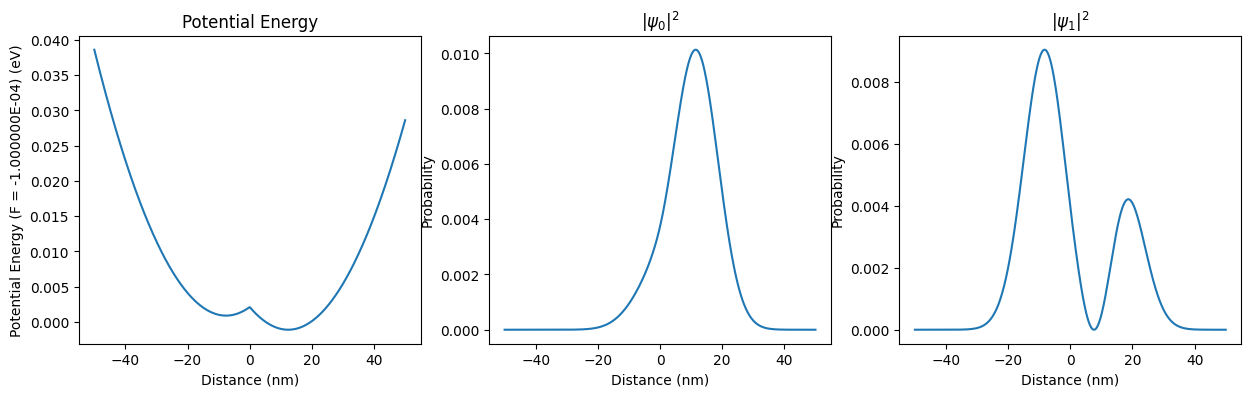

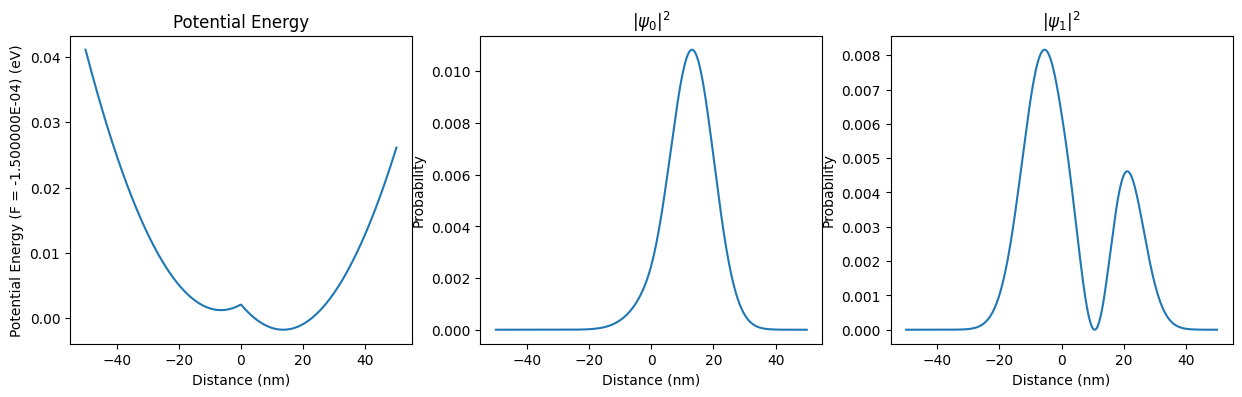

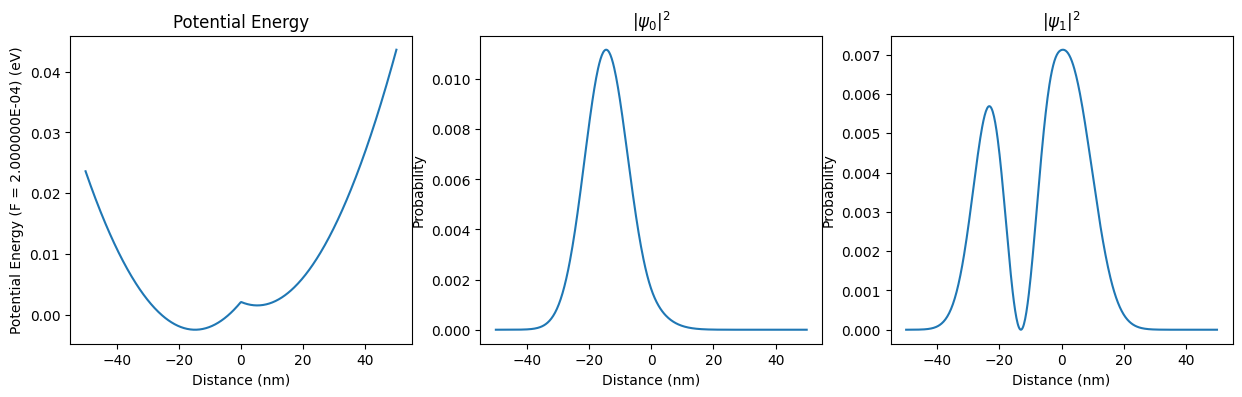

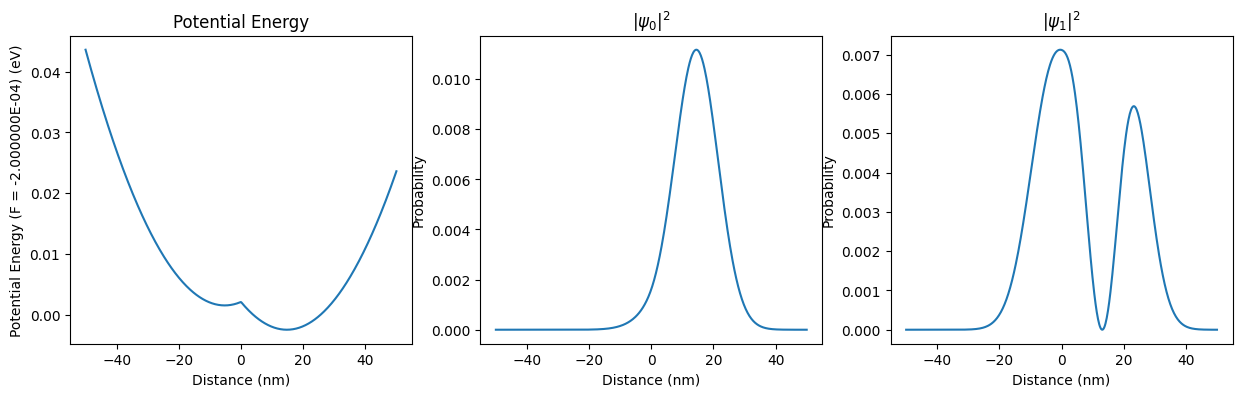

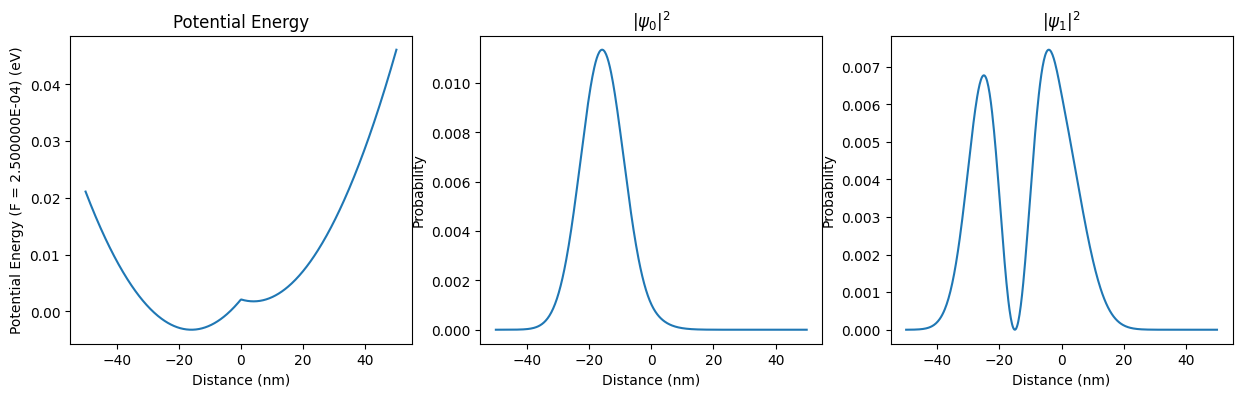

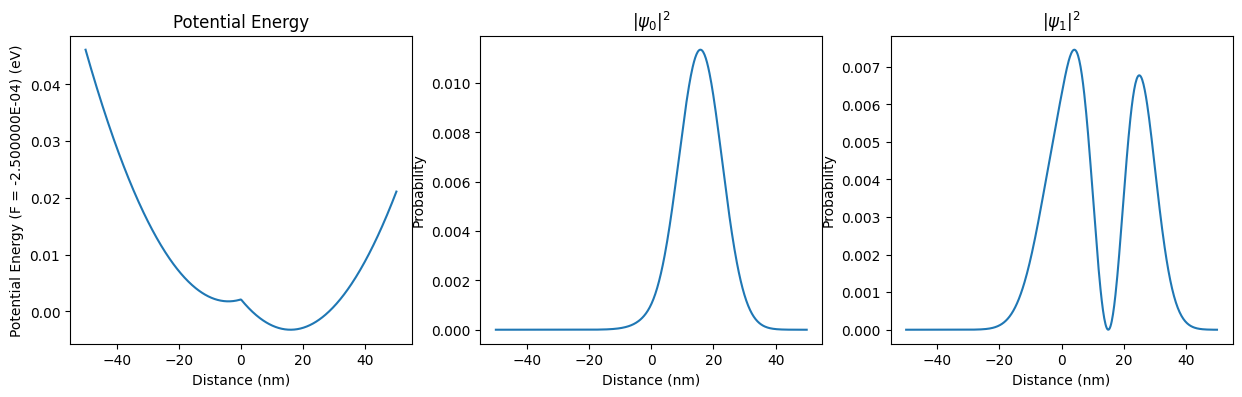

In [33]:
FArray = np.array([5, 10, 15] + [-5, -10, -15] + [20, -20, 25, -25]) * 1e-5
eigen1 = np.array([])
eigen2 = np.array([])

for F in FArray:
    U = np.array([VF(alpha, F, x1, x2, x) for x in X])
    W, V = compute_eigenvalue_eigenstates(U)
    eigen1 = np.append(eigen1, W[0])
    eigen2 = np.append(eigen2, W[1])
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    Psi0 = np.multiply(V[:, 0], V[:, 0])
    Psi1 = np.multiply(V[:, 1], V[:, 1])
    plot_graph(X, U, 'Distance (nm)', f'Potential Energy (F = {F:2E}) (eV)', r'Potential Energy', axes[0])
    plot_graph(X, Psi0, 'Distance (nm)', 'Probability', r'$|\psi_0|^2$', axes[1])
    plot_graph(X, Psi1, 'Distance (nm)', 'Probability', r'$|\psi_1|^2$', axes[2])
    plt.show()


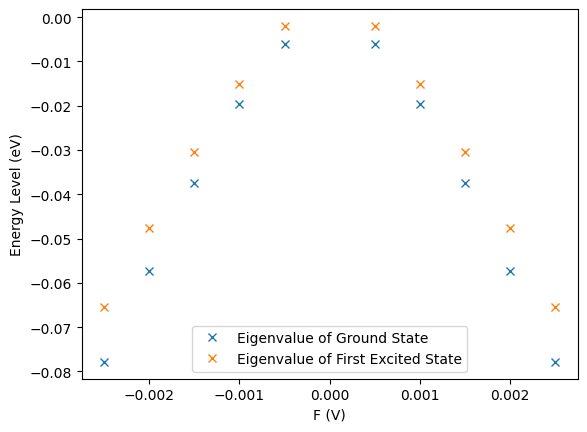

In [26]:
plt.plot(FArray, eigen1, 'x', label='Eigenvalue of Ground State')
plt.plot(FArray, eigen2, 'x', label='Eigenvalue of First Excited State')
plt.ylabel('Energy Level (eV)')
plt.xlabel('F (V)')
plt.legend()

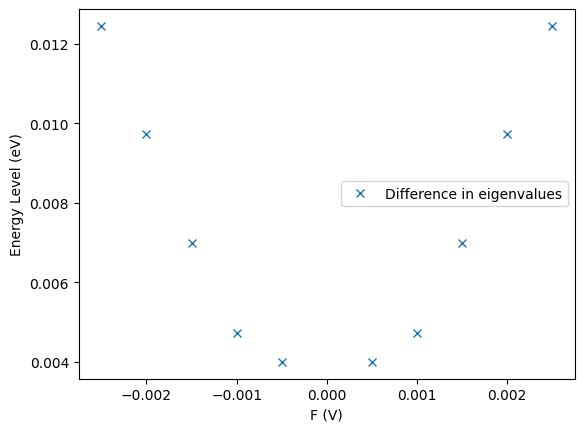

In [27]:
plt.plot(FArray, eigen2 - eigen1, 'x', label='Difference in eigenvalues')
plt.ylabel('Energy Level (eV)')
plt.xlabel('F (V)')
plt.legend()

#### i)
The probability density for the ground state goes from uni-modal to bi-modal as the separation distance $R$ increases.
The probability density for both states begin to converge (i.e. look more similar)

##### ii)
It looks like the energy gap decreases between first two eigenstates as the centre-to-centre dot separation increases over time (but plateau onces seperation is great enough) 

The Hamiltonian parameter is modified by the separation between dots would tbe entries in the diagonal (as the potential energy 
Dot separation is physically represented by the separation of the gates used to create the quantum dots.

A small dot-to-dot separation is desirable to allow for electrons to transition easily between quantum dots. 
##### iii)

When the sign of $F$ changes, the probability density function shifts in the opposite direction.
For instance, a positive $F$ encourages electrons to the left of the centre of the dot, while a negative $F$ encourages electrons to move to the right side.

It appears that the energy gap between the lowest energy as the magnitude of $F$ increases.

From A, the energy difference is only dependent on the coupling terms $t$ and $t*$.
This means that $F$ affects $t$ in our Hamiltonian.

Values of $F$ where a qubit can operate is ???

### Part D

Recall for Finite Difference Method, for some arbitrary function $T$ and differential equations $\frac{\partial T}{\Delta t} = \alpha \frac{\partial^2 T}{\Delta x^2}$, that we choose time steps $\partial t$ and $\partial x$ such that $\frac{\alpha \Delta t}{\Delta x^2} = \gamma << 1$

## Discussion

## Conclusion